In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.tsa.api as smt
from pandas.plotting import autocorrelation_plot
import itertools
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from kneed import KneeLocator
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SelectFromModel
import time
# use automatically configured the lasso regression algorithm
from numpy import arange
%matplotlib inline


# **2 Methods**

### 2.1 Data Pre-Processing 

In [2]:
#Import data

df = pd.read_csv(r'C:\Users\17203\Desktop\ARPAE_Modeling\H1_RS4_prob.csv', parse_dates = ["timestamp"])


#df1 is created seperately for the lag values, used in later sections. 
df1 = df
df1 = df1.fillna(0)

# Create 5 min averages.
df1.set_index("timestamp", inplace=True)
df1.index = pd.to_datetime(df1.index)
df1 = df1.resample(rule = '5min').mean()

#Occupied round 1 or 0. 
df1["occupied"] = df1["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)


#30 day interval: 2019-11-26 through 2019-12-25
df = (df[(df['timestamp'] >= '2019-11-26 00:00:00') & (df['timestamp'] < '2019-12-26 00:00:00')])

#Determine the distribution of NaN values. 
count_nan = len(df) - df.count()
print(count_nan)

#forward fill NaN values - when investigating data. 
#df = df.fillna(method = "ffill")

#fill NaN with 0
df = df.fillna(0)


# Create 5 min averages.
df.set_index("timestamp", inplace=True)
df.index = pd.to_datetime(df.index)
df_avg = df.resample(rule = '5min').mean()

#round occupied/unoccupied
df_avg["occupied"] = df_avg["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)

#view first 5 rows of data. 
df_avg.tail()

timestamp         0
hub               0
audio         11002
co2eq             0
light             0
rh                0
temp              0
img          126369
occupied       1355
dtype: int64


,audio,co2eq,light,rh,temp,img,occupied
timestamp,,,,,,,
2019-12-25 23:35:00,0.017800,0.806206,0.883883,1.000000,0.810217,0.0,0
2019-12-25 23:40:00,0.018271,0.806206,0.883883,0.987051,0.810217,0.0,0
2019-12-25 23:45:00,0.009635,0.806206,0.883883,0.971828,0.810217,0.0,0
2019-12-25 23:50:00,0.034479,0.806206,0.883883,0.974527,0.810217,0.0,0
2019-12-25 23:55:00,0.028034,0.806206,0.883883,0.987476,0.810217,0.0,0


### 2.2 Time Series 


(-0.3, 0.3)

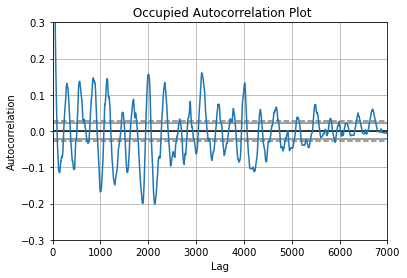

In [3]:
autocorrelation_plot(df_avg.occupied)
plt.title(' Occupied Autocorrelation Plot')
plt.xlim([0, 7000])
plt.ylim([-0.30,0.30])

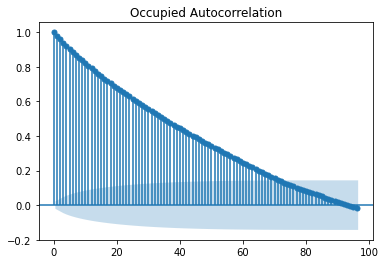

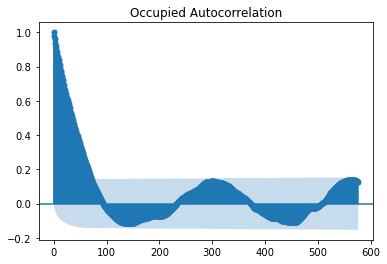

In [4]:
# 8 and 48 hours / figures 3 and 4. 
lags = [96, 576]

#alpha = 0.5 for 95% conf..
for l in lags:
    titles = "occupied"+ str(l)
    (smt.graphics.plot_acf(df_avg["occupied"],lags=l,alpha=0.05,title="Occupied Autocorrelation"))

#### 2.2.1 Offsetting Data

In [5]:
#keep last 8 hours from 11-25
df_1 = (df1.occupied[(df1.index >= '2019-11-25 16:00:00') & (df1.index < '2019-12-26 00:00:00')])

#convert to series
OA = pd.Series(df_1)

# 96 equal 8 hours for lag // add to dataframe
df_avg["lag8_occupied"] = OA.shift(periods=96)
df_avg["lag7_occupied"] = OA.shift(periods=84)
df_avg["lag6_occupied"] = OA.shift(periods=72)
df_avg["lag5_occupied"] = OA.shift(periods=60)
df_avg["lag4_occupied"] = OA.shift(periods=48)
df_avg["lag3_occupied"] = OA.shift(periods=36)
df_avg["lag2_occupied"] = OA.shift(periods=24)
df_avg["lag1_occupied"] = OA.shift(periods=12)

### 2.3 Data Exploration

1    7049
0    1591
Name: occupied, dtype: int64


Text(0.5, 1.0, 'Occupancy Distribution')

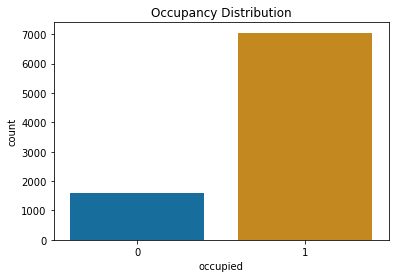

In [6]:
#Occupancy Distribution 
print(df_avg['occupied'].value_counts())
sns.countplot(x='occupied', data = df_avg, palette = 'colorblind').set_title('Occupancy Distribution')

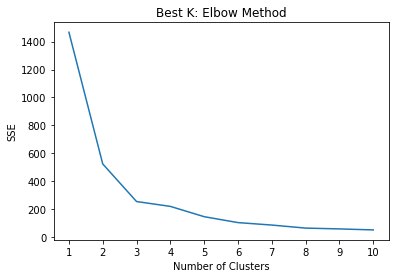

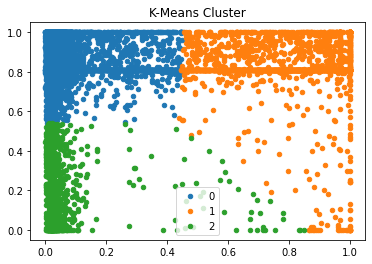

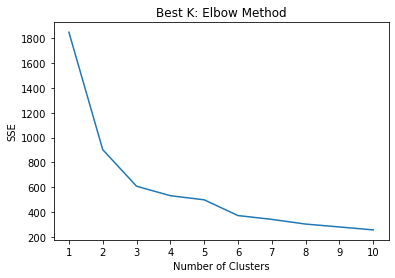

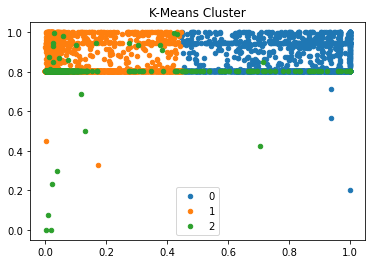

{'Best K:': 3}

In [7]:
#create a kmeans function
def km(x):
    kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 1,
    "max_iter": 300,
    "random_state": 0,
   }
    sse = []
    for k in range(1, 11):
         kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
         kmeans.fit(x)
         sse.append(kmeans.inertia_)

    #Elbow method
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.title("Best K: Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
    #Pick best k
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    
    kmeans = KMeans(
    init="k-means++",
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=0)
    
    labels = kmeans.fit_predict(x)
    u_labels = np.unique(labels)
 
    #plotting the results:
 
    for i in u_labels:
        plt.scatter(x[labels == i , 0] , x[labels == i , 1] , label = i, s=20)
    plt.title("K-Means Cluster")
    plt.legend()
    plt.show()
    
    
    return{"Best K:":kl.elbow}


#audio and images
df_v= df_avg.iloc[:,[0, 4]]
Audio_Images = df_v.to_numpy()


#environmental data
df_4 = df_avg.iloc[:, 1:5]
Environmental = df_4.to_numpy()

#audio and images + environmental 
df_v= df_avg.iloc[:, 0:5]
Sensor_mod = df_v.to_numpy()


km(Audio_Images)
km(Sensor_mod)

Text(0.5, 1.0, 'Mid-Day Correlation Matrix')

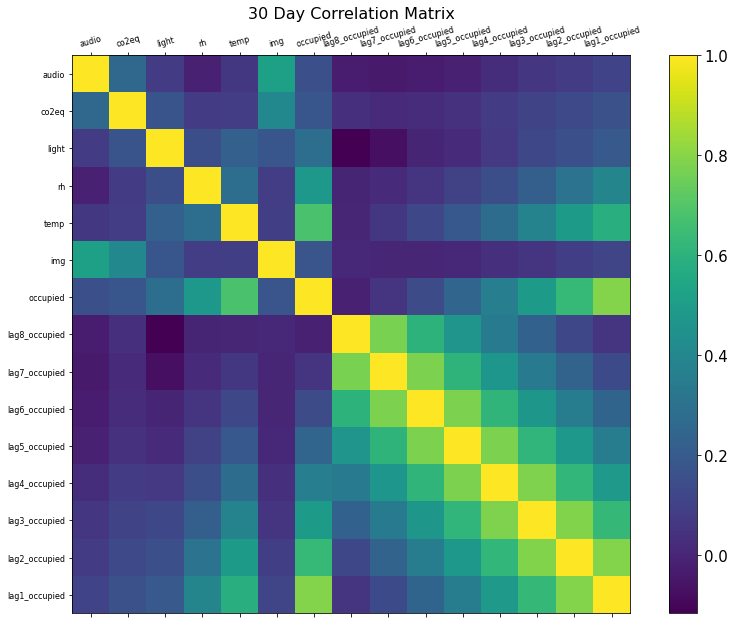

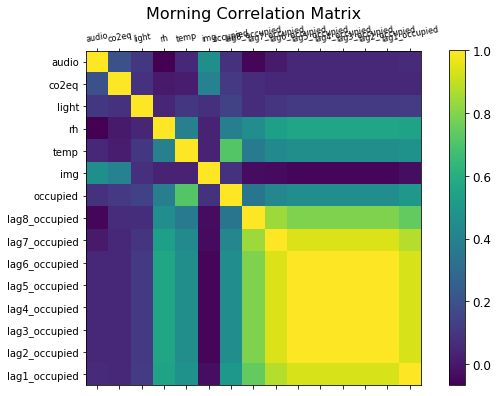

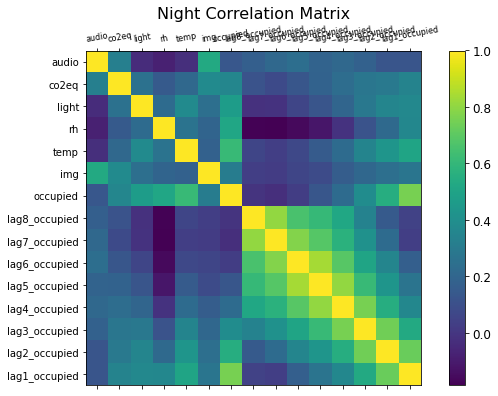

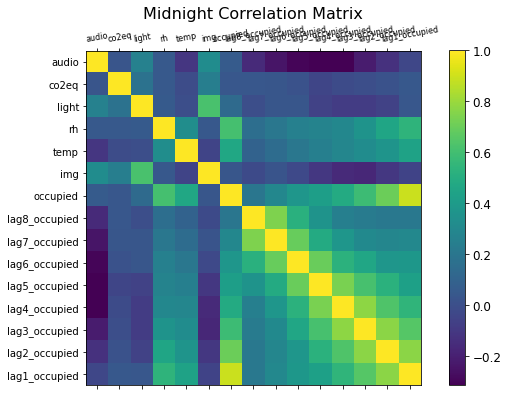

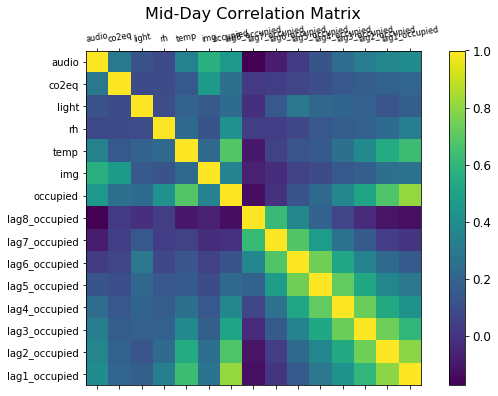

In [8]:
# All data
f = plt.figure(figsize=(14, 10))
plt.matshow(df_avg.corr(), fignum=f.number)
plt.xticks(range(df_avg.shape[1]), df_avg.columns, fontsize=8, rotation=15)
plt.yticks(range(df_avg.shape[1]), df_avg.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
figure_title = plt.title('30 Day Correlation Matrix', fontsize=16)


# Morning - think about what hours? 6am - 10am
df_avg_morning = df_avg.between_time('06:00','10:00')

f = plt.figure(figsize=(10, 6))
plt.matshow(df_avg_morning.corr(), fignum=f.number)
plt.xticks(range(df_avg_morning.shape[1]), df_avg_morning.columns, fontsize=8, rotation=10)
plt.yticks(range(df_avg_morning.shape[1]), df_avg_morning.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Morning Correlation Matrix', fontsize=16)


# Night - 6pm - 10pm
df_avg_night = df_avg.between_time('18:00','22:00')


f = plt.figure(figsize=(10, 6))
plt.matshow(df_avg_night.corr(), fignum=f.number)
plt.xticks(range(df_avg_night.shape[1]), df_avg_night.columns, fontsize=8, rotation=10)
plt.yticks(range(df_avg_night.shape[1]), df_avg_night.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Night Correlation Matrix', fontsize=16)


# Night - 11pm - 5am
df_avg_midnight = df_avg.between_time('23:00','05:00')


f = plt.figure(figsize=(10, 6))
plt.matshow(df_avg_midnight.corr(), fignum=f.number)
plt.xticks(range(df_avg_midnight.shape[1]), df_avg_midnight.columns, fontsize=8, rotation=10)
plt.yticks(range(df_avg_midnight.shape[1]), df_avg_midnight.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Midnight Correlation Matrix', fontsize=16)


# midday - 11am - 5pm
df_avg_midday = df_avg.between_time('11:00','17:00')


f = plt.figure(figsize=(10, 6))
plt.matshow(df_avg_midday.corr(), fignum=f.number)
plt.xticks(range(df_avg_midday.shape[1]), df_avg_midday.columns, fontsize=8, rotation=10)
plt.yticks(range(df_avg_midday.shape[1]), df_avg_midday.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Mid-Day Correlation Matrix', fontsize=16)

# **3 Model Construction**

### 3.1 AR Model

In [9]:
# split the data into test/train
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

Optimization terminated successfully.
         Current function value: 0.233208
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               occupied   No. Observations:                 5472
Model:                          Logit   Df Residuals:                     5463
Method:                           MLE   Df Model:                            8
Date:                Sun, 17 Jan 2021   Pseudo R-squ.:                  0.5419
Time:                        22:24:20   Log-Likelihood:                -1276.1
converged:                       True   LL-Null:                       -2785.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6050      0.134     -4.528      0.000      -0.867      -0.343
lag8_occupied    -1.

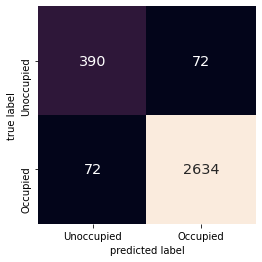

In [10]:
#Create LR function 
def LR(X_train):
    logit_mod = sm.Logit(y_train, X_train)
    logit_res = logit_mod.fit()
    print(logit_res.summary())
    print(logit_res.summary2())
    logit_test_probs = logit_res.predict(X_test)
    logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: 1 if (x > 0.5) else 0)

    mat = pd.DataFrame(confusion_matrix(logit_test_preds, y_test), columns = ["Unoccupied", "Occupied"], index = ["Unoccupied", "Occupied"])
    fig, ax = plt.subplots()
    sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
    ax.set(xlabel = "predicted label", ylabel = "true label")

    r_squared = r2_score(y_test, logit_test_preds)

    print("AIC:", logit_res.aic)
    print("RMSE:", rmse(y_test, logit_test_preds))
    print("R-Squared:", r2_score(y_test, logit_test_preds))
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print("Adj. R-Squared:", adjusted_r_squared)
    
LR(X_train)

#### 3.1.1 AR Lasso

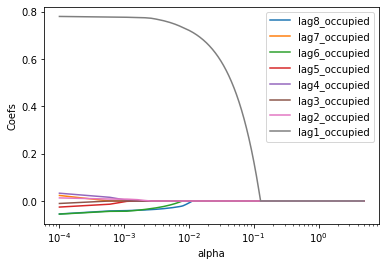

In [11]:
#for sklearn you do not need to add a constant

y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = (df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = (df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

#Create Graph
alphas = np.linspace(0.0001, 5, num=10000)

def alphaLassoGraph(X_train):   
    ridge = Ridge()
    coefs = []
    lasso = Lasso()
    coefs = []

    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit((X_train), y_train)
        coefs.append(lasso.coef_)

    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('Coefs')
    ax.legend(X_train, prop={'size': 10})

alphaLassoGraph(X_train)

In [12]:
#lasso regresson loop
alpha = [1, 0.001,0.005, 0.01, 0.02,0.09, 0.13, 10]
for a in alpha:
  model_lasso = Lasso(alpha=a)
  model_lasso.fit(X_train, y_train)
  pred_train_lasso= model_lasso.predict(X_train)
  print("RMSE Data:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
  print("R-Squared Data:" ,r2_score(y_train, pred_train_lasso))
  pred_test_lasso = model_lasso.predict(X_test)
  print("RMSE Predict:" ,np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
  print("R-Squared Predict:" ,r2_score(y_test, pred_test_lasso))
  print("Model Intercept:", (model_lasso.intercept_))
  print("Model Coefficents:")
  print(pd.Series(model_lasso.coef_, index = X_train.columns))
  

RMSE Data: 0.40466514312812796
R-Squared Data: 0.0
RMSE Predict: 0.3580851630867463
R-Squared Predict: -0.029374087765412504
Model Intercept: 0.7936769005847953
Model Coefficents:
lag8_occupied   -0.0
lag7_occupied   -0.0
lag6_occupied    0.0
lag5_occupied    0.0
lag4_occupied    0.0
lag3_occupied    0.0
lag2_occupied    0.0
lag1_occupied    0.0
dtype: float64
RMSE Data: 0.2509441753543697
R-Squared Data: 0.6154412958690803
RMSE Predict: 0.20514957912617562
R-Squared Predict: 0.6621360628040047
Model Intercept: 0.23501536342273033
Model Coefficents:
lag8_occupied   -0.040914
lag7_occupied    0.000000
lag6_occupied   -0.043354
lag5_occupied   -0.003880
lag4_occupied    0.005754
lag3_occupied    0.000000
lag2_occupied    0.007951
lag1_occupied    0.777288
dtype: float64
RMSE Data: 0.25177464066014515
R-Squared Data: 0.6128917957277755
RMSE Predict: 0.2054813633569467
R-Squared Predict: 0.6610423381779927
Model Intercept: 0.23040386011490377
Model Coefficents:
lag8_occupied   -0.029716
la

In [13]:
#CV, find best alpha and create model

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from numpy import arange
#cv = RepeatedKFold(n_splits=5, n_repeats=2,random_state= 1) this alternatively could be used to, 
    #It can be used when one requires to run KFold n times, producing different splits in each repetition.
    #This was also tested, the alpha changed but the metrics remained the same until the hundreth place
    #metrics sometimes worse/better
def LassoCV1(X_train):
    cv = KFold(n_splits=5)

    lassocv = LassoCV(alphas=None ,cv=cv,max_iter=10000)
    lassocv.fit(X_train, y_train)
    lasso = Lasso(alpha=lassocv.alpha_)
    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(X_train, y_train)

    print("RMSE:", rmse(y_test, lassocv.predict(X_test)))
    print(pd.Series(lasso.coef_, index=X_test.columns))
    print("Alpha:", lassocv.alpha_)
    print("Intercept:", lassocv.intercept_) 
    print("R-Squared:", r2_score(y_test,lasso.predict(X_test)))
    
    
LassoCV1(X_train)

RMSE: 0.20528630902495515
lag8_occupied   -0.034967
lag7_occupied   -0.000000
lag6_occupied   -0.028789
lag5_occupied   -0.000000
lag4_occupied    0.000000
lag3_occupied    0.000000
lag2_occupied    0.000000
lag1_occupied    0.768950
dtype: float64
Alpha: 0.0031530986411019467
Intercept: 0.23299568370870816
R-Squared: 0.6616855476557564


#### 3.1.2 AR Ridge Regression

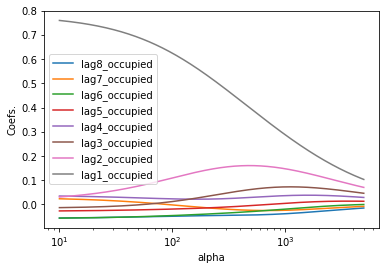

In [14]:
# Create Graph

def alphaRidgeGraph(X_train):
    alphas = np.linspace(10, 5000, num=10000)

    ridge = Ridge()
    coefs = []

    for a in alphas:
        ridge.set_params(alpha = a)
        ridge.fit(X_train, y_train)
        coefs.append(ridge.coef_)


    np.shape(coefs)

    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('Coefs.')
    ax.legend(X_train, prop={'size': 10})
    
alphaRidgeGraph(X_train)


In [15]:
#Ridge Regression Loop
alpha = [1,10, 100, 500, 1000, 2500, 5000]

for a in alpha:
  rr = Ridge(alpha = a)
  rr.fit(X_train, y_train) 
  pred_train_rr= rr.predict(X_train)
  print("RMSE Data:" , np.sqrt(mean_squared_error(y_train,pred_train_rr)))
  print("R-Squared Data:", r2_score(y_train, pred_train_rr))
  pred_test_rr= rr.predict(X_test)
  print("RMSE Predict:" , np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
  print("R-Squared Predict:", r2_score(y_test, pred_test_rr))
  print(pd.Series(rr.coef_, index = X_train.columns))


RMSE Data: 0.25075000016545557
R-Squared Data: 0.6160361920783246
RMSE Predict: 0.20570990123273605
R-Squared Predict: 0.6602879365025109
lag8_occupied   -0.057416
lag7_occupied    0.027937
lag6_occupied   -0.057881
lag5_occupied   -0.027854
lag4_occupied    0.037482
lag3_occupied   -0.015335
lag2_occupied    0.017099
lag1_occupied    0.778795
dtype: float64
RMSE Data: 0.2508085249417308
R-Squared Data: 0.6158569376947456
RMSE Predict: 0.20565025600569825
R-Squared Predict: 0.6604849057834075
lag8_occupied   -0.055799
lag7_occupied    0.023596
lag6_occupied   -0.056232
lag5_occupied   -0.026525
lag4_occupied    0.034956
lag3_occupied   -0.013008
lag2_occupied    0.030995
lag1_occupied    0.759656
dtype: float64
RMSE Data: 0.2539519872087221
R-Squared Data: 0.6061674229022924
RMSE Predict: 0.2079632316804485
R-Squared Predict: 0.6528048153164863
lag8_occupied   -0.048241
lag7_occupied   -0.001674
lag6_occupied   -0.045754
lag5_occupied   -0.018922
lag4_occupied    0.023172
lag3_occupied

In [16]:
#Find the best alpha and create model
def RidgeCV1(X_train):
    
    alphas = np.arange(0.0001,1000,1)
    cv = RepeatedKFold(n_splits=5, n_repeats=2)


    ridgecv = RidgeCV(alphas = alphas, cv=5, normalize = False )
    ridgecv.fit(X_train, y_train)

    ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = False)
    ridge4.fit(X_train, y_train)
    mean_squared_error(y_test, ridge4.predict(X_test))
    print("RMSE", rmse(y_test, ridge4.predict(X_test)))
    print(pd.Series(ridge4.  coef_, index=X_test.columns))
    print(ridgecv.alpha_)
    print("Model Intercept:", (ridgecv.intercept_))
    print(r2_score(y_test,ridge4.predict(X_test)))
    
RidgeCV1(X_train)

RMSE 0.20568798125968835
lag8_occupied   -0.057032
lag7_occupied    0.026925
lag6_occupied   -0.057500
lag5_occupied   -0.027542
lag4_occupied    0.036888
lag3_occupied   -0.014836
lag2_occupied    0.020344
lag1_occupied    0.774407
dtype: float64
3.0001
Model Intercept: 0.23601232600694755
0.6603603305145773


#### 3.1.3 AR Best Subset Selection

In [17]:
y = (df_avg.occupied)
X = sm.add_constant(df_avg)
X = X.drop(columns=["occupied","co2eq", "light", "rh", "temp","img", "audio"])
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

processSubset(X)

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16081b2d160>,
 'RSS': 476.2420133856032}

In [18]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
model4 = getBest(9)
model4["model"].summary()

Processed 1 models on 9 predictors in 0.015377283096313477 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               occupied   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1862.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:26:15   Log-Likelihood:                 260.73
No. Observations:                8640   AIC:                            -503.5
Df Residuals:                    8631   BIC:                            -439.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2122      0.008     26.272      0.000       0.196       0.228
lag8_occupied    -0.0387      0.011     -3.654      0.000      -0.060      -0.018
lag7_occupied     0.0107      0.013      0.807      0.420      -0.015       0.037
lag6_occupied    -0.0474      0.013     -3.565      0.000      -0.074      -0.021
lag5_occupied    -0.0057      0.013     -0.427      0.670      -0.032       0.020
lag4_occupied     0.0060      0.013      0.449      0.654      -0.020       0.032
lag3_occupied    -0.0004      0.014     -0.031      0.975      -0.027       0.026
lag2_occupied     0.0386      0.014      2.838      0.005       0.012       0.065
lag1_occupied     0.7761      0.011     72.125      0.000       0.755       0.797
==============================================================================
Omnibus:                     2328.384   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38567.603
Skew:                          -0.852   Prob(JB):                         0.00
Kurtosis:                      13.209   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,10):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 9 models on 1 predictors in 0.05753636360168457 seconds.
Processed 36 models on 2 predictors in 0.22964787483215332 seconds.
Processed 84 models on 3 predictors in 0.540142297744751 seconds.
Processed 126 models on 4 predictors in 0.9270243644714355 seconds.
Processed 126 models on 5 predictors in 0.8233609199523926 seconds.
Processed 84 models on 6 predictors in 0.4816157817840576 seconds.
Processed 36 models on 7 predictors in 0.22320032119750977 seconds.
Processed 9 models on 8 predictors in 0.0674588680267334 seconds.
Processed 1 models on 9 predictors in 0.010911941528320312 seconds.
Total elapsed time: 3.4834086894989014 seconds.


In [20]:
for k in range(1,len(models_best)+1):
  print(k)
  print(models_best.loc[k, "model"].summary())

1
                                 OLS Regression Results                                
Dep. Variable:               occupied   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.073e+05
Date:                Sun, 17 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:26:18   Log-Likelihood:                         -163.37
No. Observations:                8640   AIC:                                      328.7
Df Residuals:                    8639   BIC:                                      335.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [21]:
df2 = pd.DataFrame()

df2["Adusted R Square"]=(models_best.apply(lambda row: row[1].rsquared_adj, axis=1))
df2["R Square"]=(models_best.apply(lambda row: row[1].rsquared, axis=1))
df2["AIC"]=(models_best.apply(lambda row: row[1].aic, axis=1))
df2["BIC"]=(models_best.apply(lambda row: row[1].aic, axis=1))
df2.head()


,Adusted R Square,R Square,AIC,BIC
1,0.925461,0.925469,328.740993,328.740993
2,0.628706,0.628749,-415.521555,-415.521555
3,0.631720,0.631805,-484.943257,-484.943257
4,0.632391,0.632518,-499.694705,-499.694705
5,0.632894,0.633064,-510.533022,-510.533022


Text(0, 0.5, 'BIC')

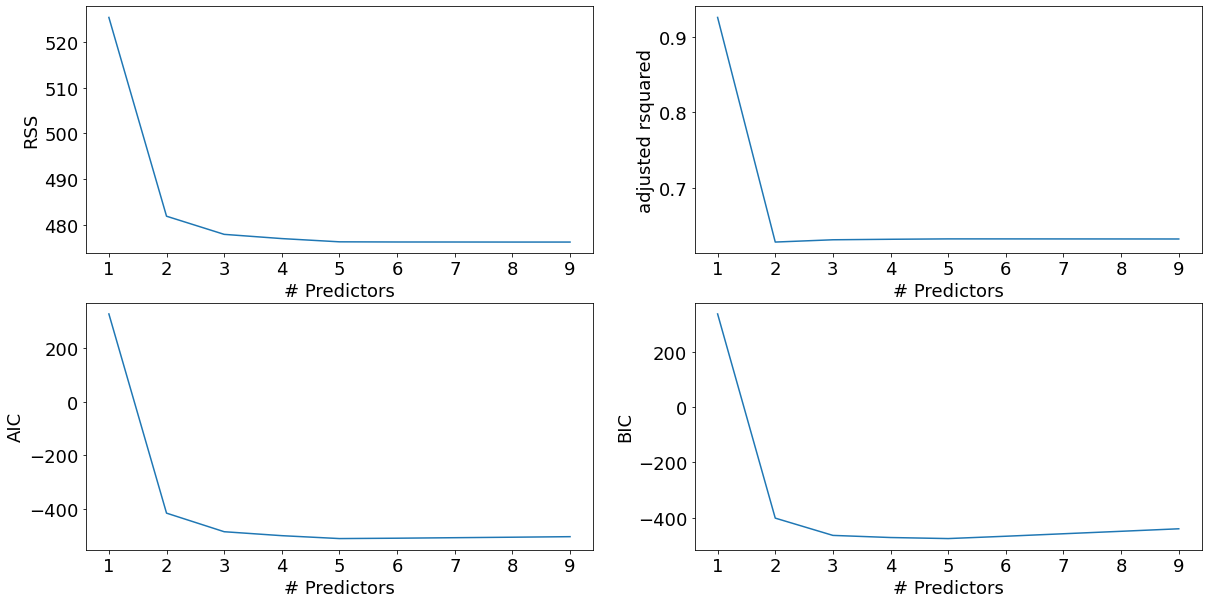

In [22]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')



rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [23]:
# split the data into test/train given best variables
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp","lag3_occupied","lag4_occupied","lag5_occupied","lag7_occupied"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp","lag3_occupied","lag4_occupied","lag5_occupied","lag7_occupied"])

#build model with best variables
def OLS1(X_train):
    OLS_mod = sm.OLS(y_train, X_train)
    OLS_res = OLS_mod.fit()
    print(OLS_res.summary())
    print(OLS_res.summary2())
    OLS_test_probs = OLS_res.predict(X_test)
    OLS_test_preds = pd.Series(OLS_test_probs)
    r_squared = r2_score(y_test, OLS_test_preds)

    print("AIC:", OLS_res.aic)
    print("RMSE:", rmse(y_test, OLS_test_preds))

    

OLS1(X_train)

                            OLS Regression Results                            
Dep. Variable:               occupied   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2187.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:26:19   Log-Likelihood:                -199.18
No. Observations:                5472   AIC:                             408.4
Df Residuals:                    5467   BIC:                             441.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2360      0.011     22.429

### 3.2 ARX1 Model

In [24]:
# split the data into test/train
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","co2eq", "light", "rh", "temp"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = X_test.drop(columns=["occupied","co2eq", "light", "rh", "temp"])

Optimization terminated successfully.
         Current function value: 0.213372
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               occupied   No. Observations:                 5472
Model:                          Logit   Df Residuals:                     5461
Method:                           MLE   Df Model:                           10
Date:                Sun, 17 Jan 2021   Pseudo R-squ.:                  0.5808
Time:                        22:26:20   Log-Likelihood:                -1167.6
converged:                       True   LL-Null:                       -2785.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0115      0.149     -6.798      0.000      -1.303      -0.720
audio             0.

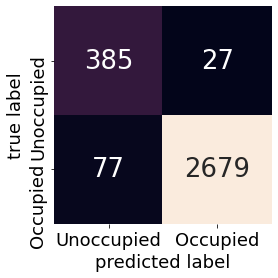

In [25]:
#LR model
LR(X_train)

#### 3.2.1 ARX1 Lasso

RMSE Data: 0.24861901654771495
R-Squared Data: 0.6225346469937814
RMSE Predict: 0.20239504152892715
R-Squared Predict: 0.6711481305470972
audio            0.032553
img              0.113890
lag8_occupied   -0.044840
lag7_occupied    0.000000
lag6_occupied   -0.043614
lag5_occupied   -0.000000
lag4_occupied    0.005052
lag3_occupied    0.000000
lag2_occupied    0.007855
lag1_occupied    0.765315
dtype: float64
RMSE Data: 0.2505660407752917
R-Squared Data: 0.6165993652639721
RMSE Predict: 0.20382539244886913
R-Squared Predict: 0.6664836322007686
audio            0.030797
img              0.017616
lag8_occupied   -0.030819
lag7_occupied   -0.000000
lag6_occupied   -0.016056
lag5_occupied   -0.000000
lag4_occupied    0.000000
lag3_occupied    0.000000
lag2_occupied    0.000000
lag1_occupied    0.750944
dtype: float64
RMSE Data: 0.2538037853947822
R-Squared Data: 0.6066269559981092
RMSE Predict: 0.20672341968856198
R-Squared Predict: 0.6569322144293464
audio            0.002450
img         

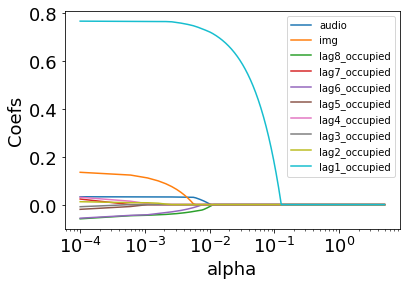

In [26]:
# split the data into test/train
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = (df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","co2eq", "light", "rh", "temp"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = (df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = X_test.drop(columns=["occupied","co2eq", "light", "rh", "temp"])

#graph
alphas = np.linspace(0.0001, 5, num=10000)
alphaLassoGraph(X_train)

#lasso loop
alpha = [0.001,0.005, 0.01, 0.02,0.09, 0.13]

for a in alpha:
  model_lasso = Lasso(alpha=a, normalize = False)
  model_lasso.fit(X_train, y_train)
  pred_train_lasso= model_lasso.predict(X_train)
  print("RMSE Data:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
  print("R-Squared Data:" ,r2_score(y_train, pred_train_lasso))
  pred_test_lasso = model_lasso.predict(X_test)
  print("RMSE Predict:" ,np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
  print("R-Squared Predict:" ,r2_score(y_test, pred_test_lasso))
  l = model_lasso.fit(X_train, y_train)
  print(pd.Series(l.coef_, index = X_train.columns))

#cross val.
LassoCV1(X_train)

RMSE Data: 0.24844622211110967
R-Squared Data: 0.6230591543146835
RMSE Predict: 0.20297622890937334
R-Squared Predict: 0.6692567900584292
audio            0.034777
img              0.132129
lag8_occupied   -0.060115
lag7_occupied    0.023422
lag6_occupied   -0.057228
lag5_occupied   -0.020872
lag4_occupied    0.032991
lag3_occupied   -0.011591
lag2_occupied    0.029915
lag1_occupied    0.746419
dtype: float64
RMSE Data: 0.2516008571533068
R-Squared Data: 0.6134260020641467
RMSE Predict: 0.20528287998766911
R-Squared Predict: 0.6616968497556197
audio            0.044527
img              0.101444
lag8_occupied   -0.051205
lag7_occupied   -0.001964
lag6_occupied   -0.045554
lag5_occupied   -0.015202
lag4_occupied    0.022403
lag3_occupied    0.012019
lag2_occupied    0.107443
lag1_occupied    0.615060
dtype: float64
RMSE Data: 0.28148181582805437
R-Squared Data: 0.5161518397053126
RMSE Predict: 0.23372945950002044
R-Squared Predict: 0.5614415456838063
audio            0.044656
img        

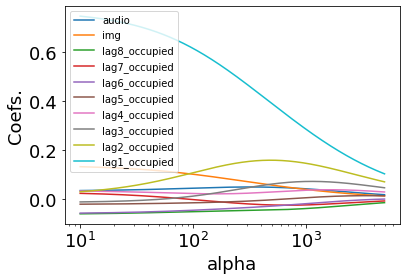

In [27]:
#graph
alphaRidgeGraph(X_train)

#Ridge loop
alpha = [10, 100, 800, 1000, 2500, 5000]
for a in alpha:
  rr = Ridge(alpha = a)
  rr.fit(X_train, y_train) 
  pred_train_rr= rr.predict(X_train)
  print("RMSE Data:" , np.sqrt(mean_squared_error(y_train,pred_train_rr)))
  print("R-Squared Data:", r2_score(y_train, pred_train_rr))
  pred_test_rr= rr.predict(X_test)
  print("RMSE Predict:" , np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
  print("R-Squared Predict:", r2_score(y_test, pred_test_rr))
  r = rr.fit(X_train, y_train) 
  print(pd.Series(r.coef_, index = X_train.columns))
    

#Cross Val
RidgeCV1(X_train)

#### 3.2.3 ARX1 Best Subset Selection

In [28]:
y = (df_avg.occupied)
X = sm.add_constant(df_avg)
X = X.drop(columns=["occupied","co2eq", "light", "rh", "temp"])
processSubset(X)

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16081c21c40>,
 'RSS': 465.89426741245137}

In [29]:
getBest(11)

Processed 1 models on 11 predictors in 0.008928060531616211 seconds.


model    <statsmodels.regression.linear_model.Regressio...
RSS                                                465.894
Name: 0, dtype: object

In [30]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,12):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 11 models on 1 predictors in 0.038164377212524414 seconds.
Processed 55 models on 2 predictors in 0.2107994556427002 seconds.
Processed 165 models on 3 predictors in 0.7668139934539795 seconds.
Processed 330 models on 4 predictors in 1.7732033729553223 seconds.
Processed 462 models on 5 predictors in 2.701711654663086 seconds.
Processed 462 models on 6 predictors in 2.885727643966675 seconds.
Processed 330 models on 7 predictors in 2.0425281524658203 seconds.
Processed 165 models on 8 predictors in 1.3426735401153564 seconds.
Processed 55 models on 9 predictors in 0.5098557472229004 seconds.
Processed 11 models on 10 predictors in 0.1096198558807373 seconds.
Processed 1 models on 11 predictors in 0.012897491455078125 seconds.
Total elapsed time: 12.71047043800354 seconds.


In [31]:
for k in range(1,len(models_best)+1):
  print(k)
  print(models_best.loc[k, "model"].summary())

1
                                 OLS Regression Results                                
Dep. Variable:               occupied   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.073e+05
Date:                Sun, 17 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:28:37   Log-Likelihood:                         -163.37
No. Observations:                8640   AIC:                                      328.7
Df Residuals:                    8639   BIC:                                      335.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Text(0, 0.5, 'BIC')

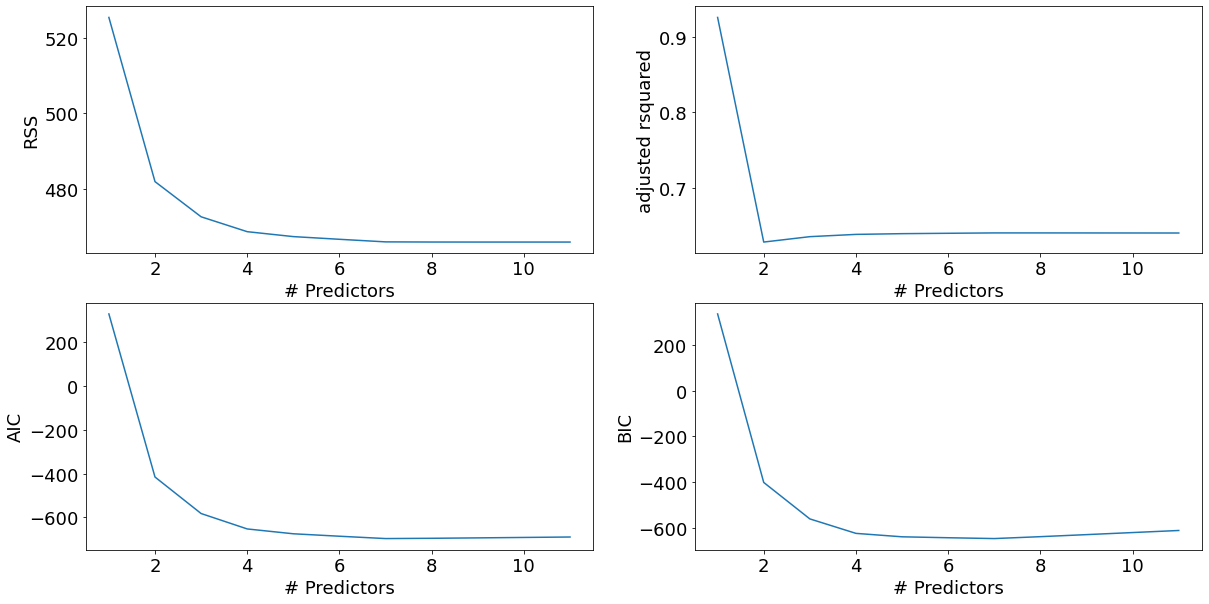

In [32]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')



rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [33]:
# split the data into test/train given best variables
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","co2eq", "light", "rh", "temp","lag3_occupied","lag4_occupied","lag5_occupied"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied", "co2eq", "light", "rh", "temp","lag3_occupied","lag4_occupied","lag5_occupied"])


OLS1(X_train)

                            OLS Regression Results                            
Dep. Variable:               occupied   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1289.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:28:38   Log-Likelihood:                -145.58
No. Observations:                5472   AIC:                             307.2
Df Residuals:                    5464   BIC:                             360.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2262      0.011     21.164

### 3.3 ARX2 Model

In [34]:
# split the data into test/train
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = X_test.drop(columns=["occupied"])

Optimization terminated successfully.
         Current function value: 0.104426
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:               occupied   No. Observations:                 5472
Model:                          Logit   Df Residuals:                     5457
Method:                           MLE   Df Model:                           14
Date:                Sun, 17 Jan 2021   Pseudo R-squ.:                  0.7949
Time:                        22:28:38   Log-Likelihood:                -571.42
converged:                       True   LL-Null:                       -2785.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -48.4008      5.231     -9.253      0.000     -58.653     -38.148
audio             2

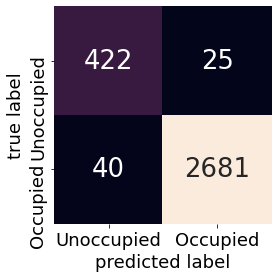

In [35]:
#Logistc Regression Model
LR(X_train)

#### 3.3.1 ARX2 Lasso

RMSE Data: 0.211426238302159
R-Squared Data: 0.7270229275093636
RMSE Predict: 0.1727415659326125
R-Squared Predict: 0.7604510439848051
audio            0.079454
co2eq            0.000000
light            0.216646
rh               0.385772
temp             0.576316
img              0.031088
lag8_occupied   -0.014244
lag7_occupied    0.000000
lag6_occupied   -0.036598
lag5_occupied   -0.000000
lag4_occupied    0.002615
lag3_occupied   -0.000000
lag2_occupied   -0.000000
lag1_occupied    0.536805
dtype: float64
RMSE Data: 0.2177357998254941
R-Squared Data: 0.7104869876276465
RMSE Predict: 0.17512249174936484
R-Squared Predict: 0.7538020490716703
audio            0.051826
co2eq            0.000000
light            0.000000
rh               0.210881
temp             0.520810
img              0.000000
lag8_occupied   -0.012812
lag7_occupied   -0.000000
lag6_occupied   -0.011184
lag5_occupied   -0.000000
lag4_occupied    0.000000
lag3_occupied    0.000000
lag2_occupied    0.000000
lag1_occupi

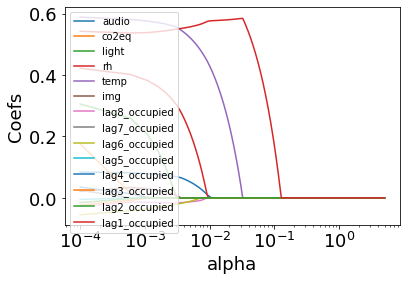

In [36]:
# split the data into test/train take constant out for sklearn
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = (df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = (df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied"])
#graph
alphaLassoGraph(X_train)

alpha = [0.001,0.005, 0.01, 0.02,0.09, 0.13]

for a in alpha:
  model_lasso = Lasso(alpha=a, normalize = False)
  model_lasso.fit(X_train, y_train)
  pred_train_lasso= model_lasso.predict(X_train)
  print("RMSE Data:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
  print("R-Squared Data:" ,r2_score(y_train, pred_train_lasso))
  pred_test_lasso = model_lasso.predict(X_test)
  print("RMSE Predict:" ,np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
  print("R-Squared Predict:" ,r2_score(y_test, pred_test_lasso))
  l = model_lasso.fit(X_train, y_train)
  print(pd.Series(l.coef_, index = X_train.columns))

#cross_val
LassoCV1(X_train)

#### 3.3.2 ARX2 Ridge

RMSE Data: 0.2106733893143046
R-Squared Data: 0.7289635061459362
RMSE Predict: 0.1734899904526073
R-Squared Predict: 0.7583707954083128
audio            0.080752
co2eq            0.131455
light            0.268811
rh               0.395122
temp             0.570692
img              0.035467
lag8_occupied   -0.030606
lag7_occupied    0.025118
lag6_occupied   -0.054834
lag5_occupied   -0.008122
lag4_occupied    0.037370
lag3_occupied   -0.022899
lag2_occupied   -0.005578
lag1_occupied    0.538626
dtype: float64
RMSE Data: 0.21735085728297543
R-Squared Data: 0.7115097625749301
RMSE Predict: 0.17184991654402043
R-Squared Predict: 0.7629176468554204
audio            0.065338
co2eq            0.042161
light            0.131108
rh               0.243733
temp             0.444551
img              0.063637
lag8_occupied   -0.033452
lag7_occupied    0.001239
lag6_occupied   -0.041997
lag5_occupied   -0.008740
lag4_occupied    0.024674
lag3_occupied    0.001573
lag2_occupied    0.068091
lag1_occu

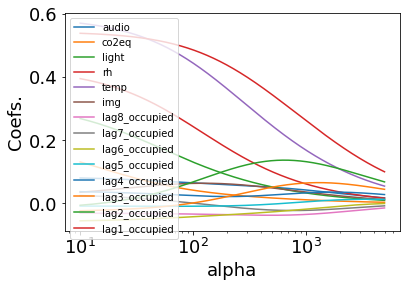

In [37]:
#graph
alphaRidgeGraph(X_train)

#Ridge loop
alpha = [10, 100, 1000, 1500, 10000]
for a in alpha:
  rr = Ridge(alpha = a)
  rr.fit(X_train, y_train) 
  pred_train_rr= rr.predict(X_train)
  print("RMSE Data:" , np.sqrt(mean_squared_error(y_train,pred_train_rr)))
  print("R-Squared Data:", r2_score(y_train, pred_train_rr))
  pred_test_rr= rr.predict(X_test)
  print("RMSE Predict:" , np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
  print("R-Squared Predict:", r2_score(y_test, pred_test_rr))
  r = rr.fit(X_train, y_train) 
  print(pd.Series(r.coef_, index = X_train.columns))
    

#Cross Val
RidgeCV1(X_train)

#### 3.3.3 ARX2 Best Subset Selection

In [38]:
y = (df_avg.occupied)
X = sm.add_constant(df_avg)
X = X.drop(columns=["occupied"])
processSubset(X)

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x160811a8f70>,
 'RSS': 335.20012913221626}

In [39]:
getBest(15)

Processed 1 models on 15 predictors in 0.011903762817382812 seconds.


model    <statsmodels.regression.linear_model.Regressio...
RSS                                                  335.2
Name: 0, dtype: object

In [40]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,16):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 15 models on 1 predictors in 0.06646394729614258 seconds.
Processed 105 models on 2 predictors in 0.4950437545776367 seconds.
Processed 455 models on 3 predictors in 3.197216510772705 seconds.
Processed 1365 models on 4 predictors in 9.670046091079712 seconds.
Processed 3003 models on 5 predictors in 20.11776113510132 seconds.
Processed 5005 models on 6 predictors in 40.10255765914917 seconds.
Processed 6435 models on 7 predictors in 53.936997175216675 seconds.
Processed 6435 models on 8 predictors in 66.21749448776245 seconds.
Processed 5005 models on 9 predictors in 57.53798794746399 seconds.
Processed 3003 models on 10 predictors in 35.964465379714966 seconds.
Processed 1365 models on 11 predictors in 16.190393447875977 seconds.
Processed 455 models on 12 predictors in 5.954977750778198 seconds.
Processed 105 models on 13 predictors in 1.4359183311462402 seconds.
Processed 15 models on 14 predictors in 0.17855548858642578 seconds.
Processed 1 models on 15 predictors in 0.0

In [41]:
for k in range(1,len(models_best)+1):
  print(k)
  print(models_best.loc[k, "model"].summary())

1
                                 OLS Regression Results                                
Dep. Variable:               occupied   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.073e+05
Date:                Sun, 17 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:36:20   Log-Likelihood:                         -163.37
No. Observations:                8640   AIC:                                      328.7
Df Residuals:                    8639   BIC:                                      335.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Text(0, 0.5, 'BIC')

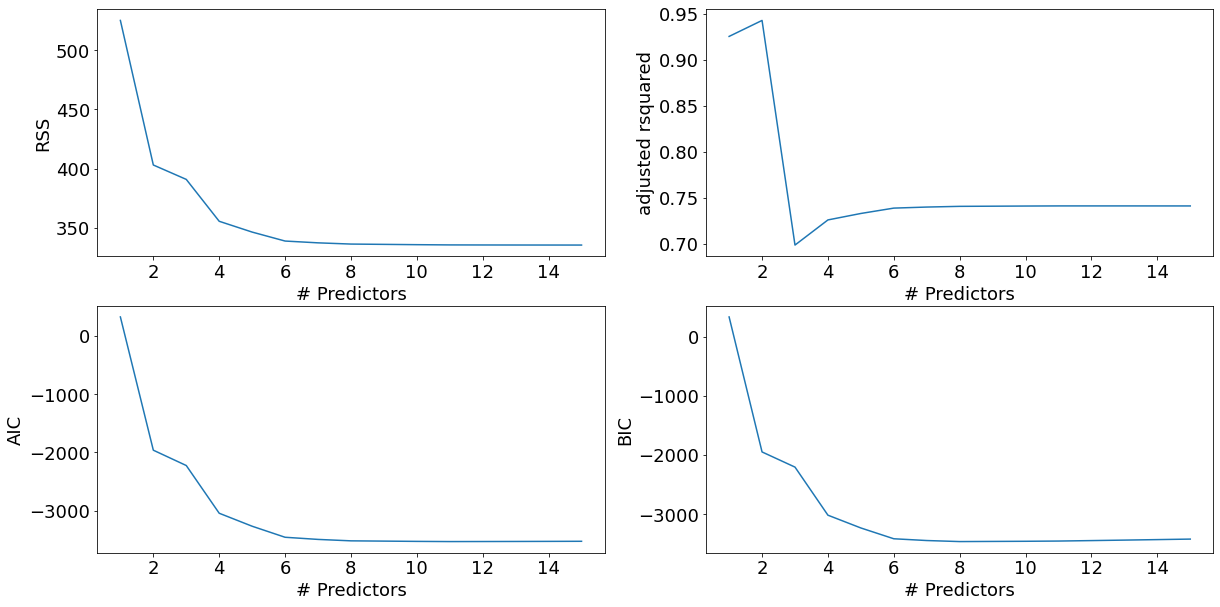

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')


rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [43]:
# split the data into test/train given best variables
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","lag3_occupied","lag2_occupied","lag3_occupied","lag4_occupied","lag5_occupied","lag7_occupied"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test= X_test.drop(columns=["occupied","lag3_occupied","lag2_occupied","lag3_occupied","lag4_occupied","lag5_occupied","lag7_occupied"])


OLS1(X_train)

                            OLS Regression Results                            
Dep. Variable:               occupied   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1630.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:36:22   Log-Likelihood:                 755.29
No. Observations:                5472   AIC:                            -1491.
Df Residuals:                    5462   BIC:                            -1425.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8893      0.054    -16.455

# **4 Discussion**


Text(0.5, 0, 'Model')

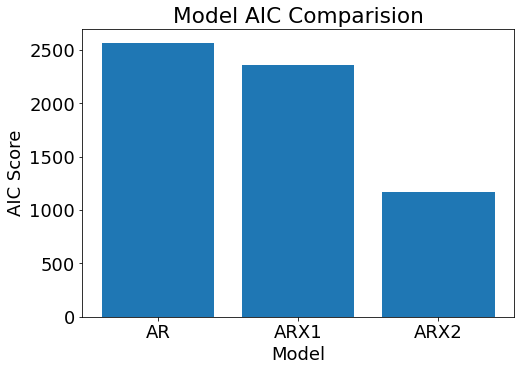

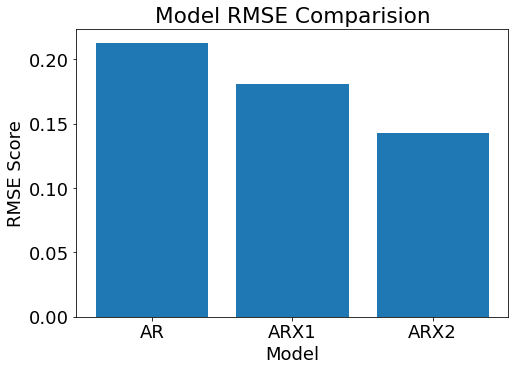

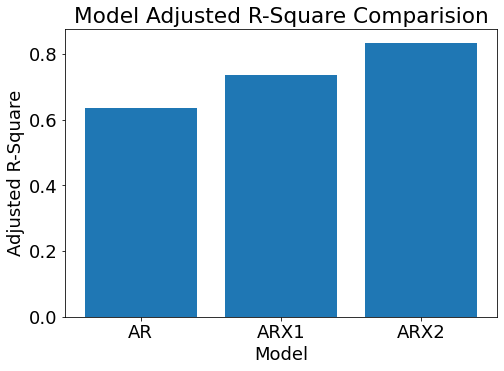

In [44]:
AIC = [2570, 2357, 1172]
RMSE = [0.2132, 0.1812, 0.1432]
AdjR_Sq = [0.6340566707115466, 0.7355401098329784, 0.8345028130220653]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
Models = ['AR', 'ARX1', 'ARX2']
ax.bar(Models, AIC)
ax.set_title('Model AIC Comparision')
ax.set_ylabel('AIC Score')
ax.set_xlabel('Model')


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['AR', 'ARX1', 'ARX2']
ax.bar(Models, RMSE)
ax.set_title('Model RMSE Comparision')
ax.set_ylabel('RMSE Score')
ax.set_xlabel('Model')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['AR', 'ARX1', 'ARX2']
ax.bar(Models, AdjR_Sq)
ax.set_title('Model Adjusted R-Square Comparision')
ax.set_ylabel('Adjusted R-Square')
ax.set_xlabel('Model')


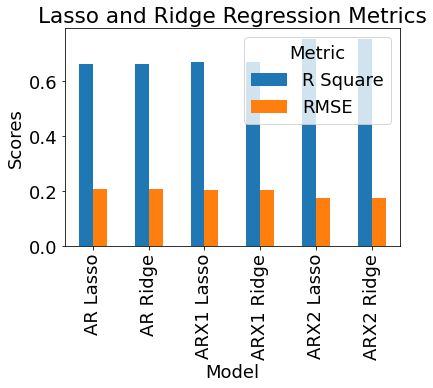

In [45]:
df = pd.DataFrame([['RMSE','AR Lasso',0.20528],['RMSE','AR Ridge',0.20568],['RMSE','ARX1 Lasso',0.20331],['RMSE','ARX1 Ridge',0.20302],['RMSE','ARX2 Lasso',0.1750],['RMSE','ARX2 Ridge',0.175542],
                   ['R Square','AR Lasso',0.66169],['R Square','AR Ridge',0.66036],['R Square','ARX1 Lasso',0.6682],['R Square','ARX1 Ridge',0.66912],['R Square','ARX2 Lasso',0.75421], ['R Square','ARX2 Ridge',0.75262]],columns=['Metric','Model','val'])

df1 = df.pivot("Model", "Metric", "val").plot(kind='bar')
df1.set_ylabel('Scores')
df1.set_title('Lasso and Ridge Regression Metrics')
plt.show()

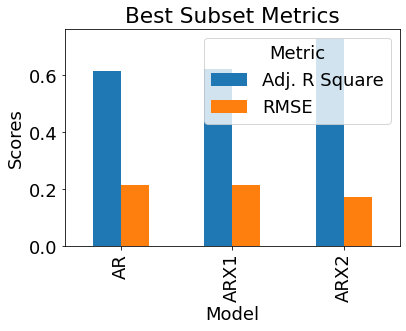

In [46]:
df = pd.DataFrame([['RMSE','AR',0.2132],['RMSE','ARX1',0.2132],['RMSE','ARX2',0.17134],
                   ['Adj. R Square','AR',0.615],['Adj. R Square','ARX1',0.622],['Adj. R Square','ARX2',0.728]]
                    ,columns=['Metric','Model','val'])

df1 = df.pivot("Model", "Metric", "val").plot(kind='bar')
df1.set_ylabel('Scores')
df1.set_title('Best Subset Metrics')
plt.show()

Text(0.5, 0, 'Model')

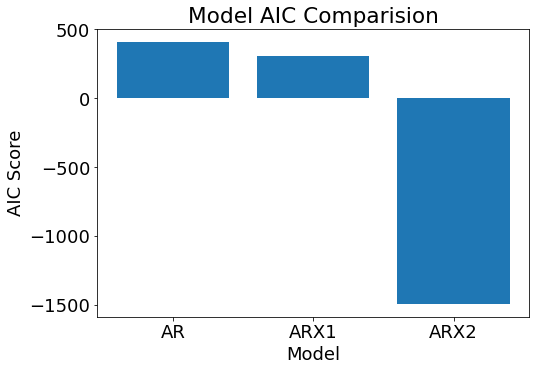

In [47]:
AIC = [408.35,307.15,-1490.58]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
Models = ['AR', 'ARX1', 'ARX2']
ax.bar(Models, AIC)
ax.set_title('Model AIC Comparision')
ax.set_ylabel('AIC Score')
ax.set_xlabel('Model')

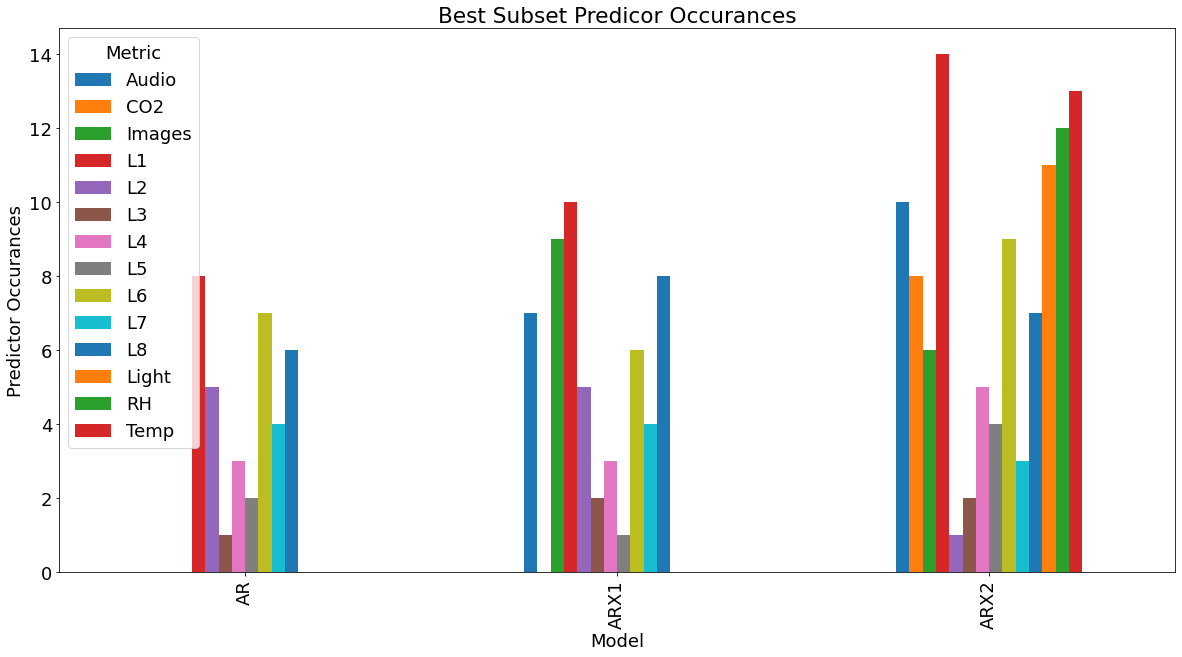

In [48]:
import datetime as DT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.interpolate as interpolate


df = pd.DataFrame([['L1','AR',8],['L2','AR',5],['L3','AR',1],['L4','AR',3],['L5','AR',2],['L6','AR',7],
                   ['L7','AR',4],['L8','AR',6],['L1','ARX1',10],['L2','ARX1',5],['L3','ARX1',2],['L4','ARX1',3],['L5','ARX1',1],['L6','ARX1',6],
                   ['L7','ARX1',4],['L8','ARX1',8],  ['Audio','ARX1',7],['Images','ARX1',9],['L1','ARX2',14],['L2','ARX2',1],['L3','ARX2',2],['L4','ARX2',5],['L5','ARX2',4],['L6','ARX2',9],
                   ['L7','ARX2',3],['L8','ARX2',7],  ['Audio','ARX2',10],['Images','ARX2',6],['Temp','ARX2',13], ['RH','ARX2',12], ['CO2','ARX2',8], ['Light','ARX2',11]],columns=['Metric','Model','val'])



df1 = df.pivot("Model", "Metric", "val").plot(kind='bar', figsize=(20,10))

df1.set_ylabel('Predictor Occurances')
df1.set_title('Best Subset Predicor Occurances')
plt.show()

### Additional ACF based off time spans from correlation plots. 

(-0.3, 0.3)

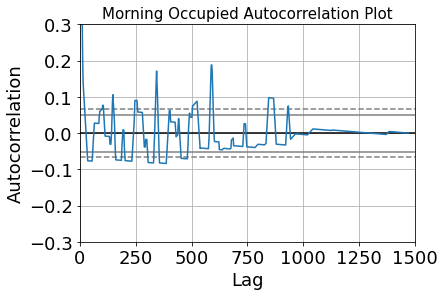

In [49]:
autocorrelation_plot(df_avg_morning.occupied)
plt.title('Morning Occupied Autocorrelation Plot',fontsize = 15)
plt.xlim([0, 1500])
plt.ylim([-0.30,0.30])

(-0.3, 0.3)

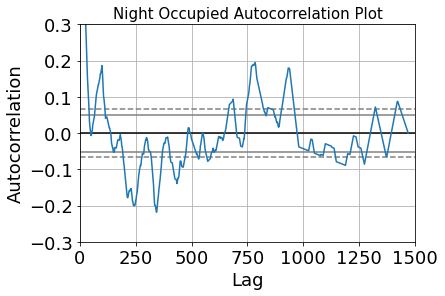

In [50]:
autocorrelation_plot(df_avg_night.occupied)
plt.title('Night Occupied Autocorrelation Plot', fontsize = 15)
plt.xlim([0, 1500])
plt.ylim([-0.30,0.30])

(-0.3, 0.3)

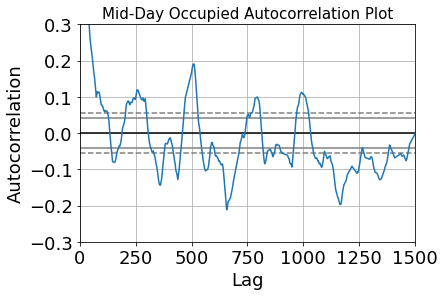

In [51]:
autocorrelation_plot(df_avg_midday.occupied)
plt.title('Mid-Day Occupied Autocorrelation Plot',fontsize = 15)
plt.xlim([0, 1500])
plt.ylim([-0.30,0.30])

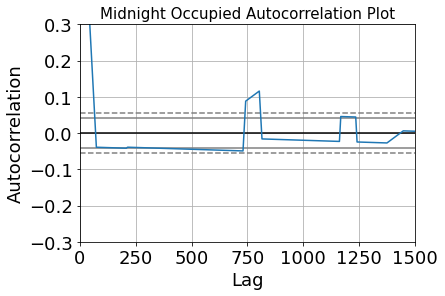

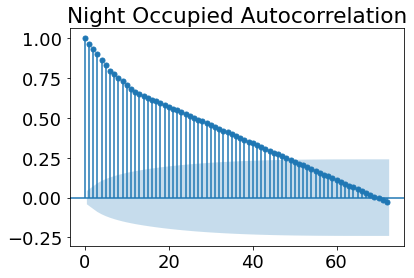

In [60]:
autocorrelation_plot(df_avg_midnight.occupied)
plt.title('Midnight Occupied Autocorrelation Plot', fontsize = 15)
plt.xlim([0, 1500])
plt.ylim([-0.30,0.30])
lags = [72]

#alpha = 0.5 for 95% conf..
for l in lags:
    titles = "occupied"+ str(l)
    (smt.graphics.plot_acf(df_avg_midnight["occupied"],lags=l,alpha=0.05,title="Night Occupied Autocorrelation"))